# Program Optimization using `tket-py`

**Download this notebook - {nb-download}`Guppy-opt-example.ipynb`**



In [24]:
from guppylang import guppy
from guppylang.std.quantum import cx, h, qubit, t, rz
from guppylang.std.qsystem import phased_x
from guppylang.std.angles import pi
from hugr.hugr.render import DotRenderer, RenderConfig
from graphviz import Digraph
from tket.passes import NormalizeGuppy, PytketPass
from pytket.passes import RemoveRedundancies, SquashRzPhasedX, AutoSquash, EulerAngleReduction, FullPeepholeOptimise
from pytket.circuit import OpType

# Configure Hugr visualizer
my_renderer = DotRenderer(RenderConfig(display_node_id=True, display_metadata=False))

def draw(hugr: Hugr) -> Digraph:
    """Draw a Hugr graph with the DotRenderer."""
    return my_renderer.render(hugr)

## Getting started - Flattening the Guppy generated HUGR

In [25]:
@guppy
def pauli_zz_rotation(q0: qubit, q1: qubit) -> None:
    cx(q0, q1)
    t(q1)
    cx(q0, q1)

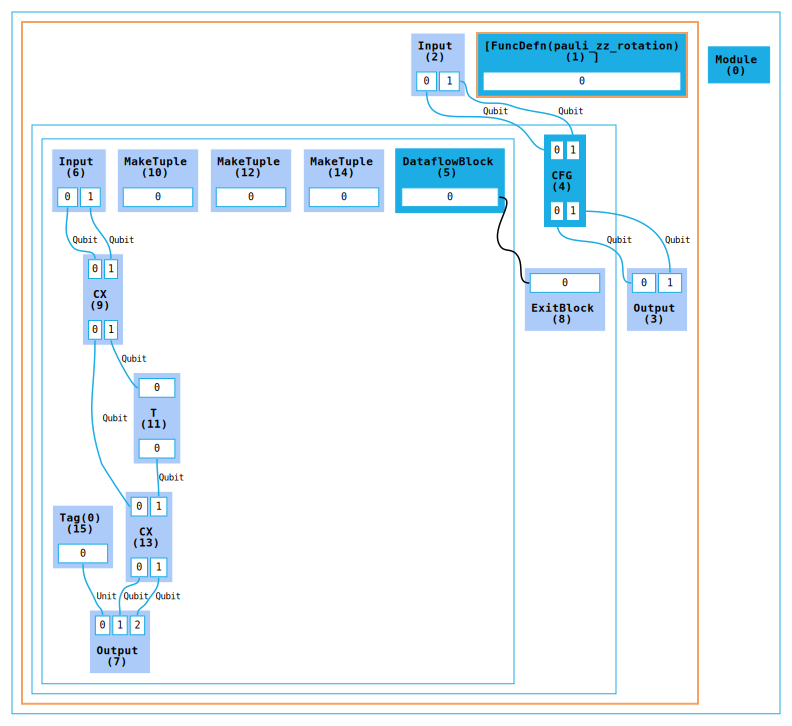

In [26]:
zz_hugr_graph = pauli_zz_rotation.compile_function().modules[0]
draw(zz_hugr_graph)

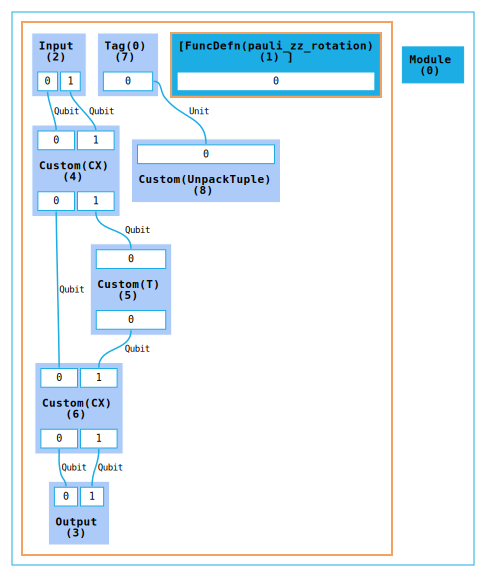

In [27]:
normalize = NormalizeGuppy()

cleaned_zz_hugr = normalize(zz_hugr_graph)

draw(cleaned_zz_hugr)

## Example 1: Cancelling redundant CX gates 

In [28]:
@guppy
def redundant_cx(q0: qubit, q1: qubit) -> None:
    h(q0)
    # Two adjacent CX gates with the same control and target can be cancelled.
    cx(q0, q1)
    cx(q0, q1)

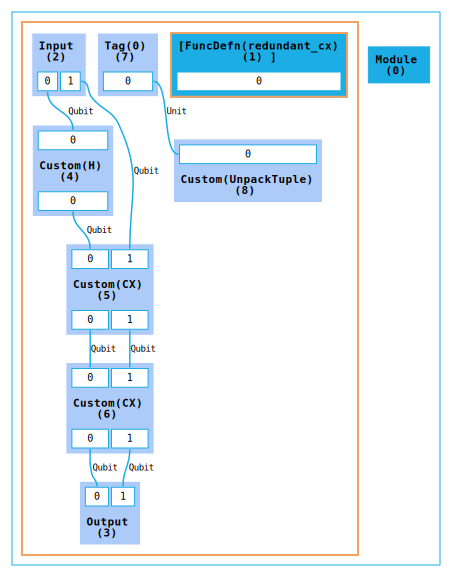

In [29]:
my_hugr_graph = normalize(redundant_cx.compile_function().modules[0]) # get normalized hugr for program above
draw(my_hugr_graph)

In [30]:
rr_pass = PytketPass(RemoveRedundancies())

optimized_hugr = rr_pass(my_hugr_graph)

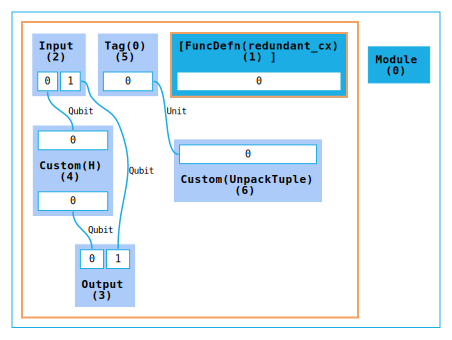

In [31]:
draw(optimized_hugr)

## Example 2: Simplifying sequences of single qubit gates

In [13]:
@guppy
def redundant_rz_gates(q0: qubit, q1: qubit) -> None:
    h(q0)
    t(q0)
    t(q0)
    

In [39]:
my_1q_hugr_graph = normalize(redundant_rz_gates.compile_function().modules[0]) # get normalized hugr for program above


In [40]:
squash_pass = PytketPass(SquashRzPhasedX())

In [41]:
optimized_1q_hugr = squash_pass(my_1q_hugr_graph)

PyTk1EncodeError: An unsupported subgraph has no qubits or bits to attach the barrier command to